<a href="https://colab.research.google.com/github/Chiosas/Jester_Jokes/blob/master/Jester_Jokes_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Initial Setup***

### ***Environment Setup***

In [0]:
import os
from pathlib import Path

In [0]:
dir_name = 'jokes'
DATA_DIR = Path(f'data/{dir_name}')
MODEL_DIR = Path(f'model/{dir_name}')

In [0]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

FIRST_RUN = not os.path.exists(str(MODEL_DIR))

In [0]:
if not IN_COLAB:
    os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES']='0'

if FIRST_RUN:
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(DATA_DIR, exist_ok=True)

In [0]:
if IN_COLAB and FIRST_RUN:
    !pip install -q --upgrade scikit-optimize
    !pip install -q -U --pre efficientnet
    !pip install -q -U --no-deps tensorflow-addons~=0.6
    # !pip install -q -U tensorflow-datasets
    # !pip install -q -U tensorflow_hub
    !pip install -q -U keras-tuner

### ***Kaggle Setup***

In [0]:
def setup_kaggle():
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Make sure you've uploaded 'kaggle.json' file into Colab
if IN_COLAB and FIRST_RUN:
    setup_kaggle()

In [0]:
import kaggle

In [0]:
if IN_COLAB and FIRST_RUN:
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(
        dataset='vikashrajluhaniwal/jester-17m-jokes-ratings-dataset',
        path=DATA_DIR,
        unzip=True,
    )

### ***Importing Dependencies***

In [10]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [11]:
from imports import *

import tensorflow_addons as tfa
# import tensorflow_datasets as tfds
# import tensorflow_hub as hub
import kerastuner as kt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
tf.__version__

'2.1.0-rc1'

In [0]:
if FIRST_RUN:
    exit()

In [0]:
%matplotlib inline

## ***Data Description***

### **Content**

![Jokes](https://short-funny.com/cartoon-jokes/400/donkey-joke.jpg)

Jester is an online joke recommender system developed by Ken Goldberg and the team at UC Berkeley. Users are presented jokes through an HTML client interface and allowed to rate jokes. Once a user rates all jokes in the gauge set, the system recommends new jokes to the user.

The dataset contains over 1.7 million continuous ratings (-10.00 to +10.00) of 150 jokes from 59,132 users. The dataset was collected between November 2006 - May 2009. The complete dataset has two CSV files:
* *jester_ratings.csv* - Ratings of jokes
* *jester_items.csv* - Contents of jokes

The ratings are real values ranging from -10.00 to +10.00.
As of May 2009, the jokes {7, 8, 13, 15, 16, 17, 18, 19} are the "gauge set".

The columns of *jester_ratings.csv* file are:

* User ID — unique ID of a website user,
* Joke ID — unique ID of a joke posted on the website,
* Rating — rating of the joke assigned by the user.

The columns of *jester_items.csv* file are:

* Joke ID — unique ID of a joke posted on the website,
* Joke Text — actual joke content.


We will use the dataset to build a collaborative filtering or hybrid recommender system model.

### ***Data Exploration***

In [0]:
# Reading the data from the file
raw_data = pd.read_csv(DATA_DIR/'jester_ratings.csv', low_memory=False)

In [16]:
print('Number of rows in the dataset:', raw_data.shape[0])
print('Number of columns in the dataset:', raw_data.shape[1])

Number of rows in the dataset: 1761439
Number of columns in the dataset: 3


In [17]:
raw_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761439 entries, 0 to 1761438
Data columns (total 3 columns):
userId    1761439 non-null int64
jokeId    1761439 non-null int64
rating    1761439 non-null float64
dtypes: float64(1), int64(2)
memory usage: 40.3 MB


In [18]:
raw_data.isna().sum()

userId    0
jokeId    0
rating    0
dtype: int64

In [19]:
raw_data.describe(include='all')

,userId,jokeId,rating
count,1.761439e+06,1.761439e+06,1.761439e+06
mean,3.272322e+04,7.071133e+01,1.618602e+00
std,1.828011e+04,4.600790e+01,5.302608e+00
min,1.000000e+00,5.000000e+00,-1.000000e+01
25%,1.720200e+04,2.100000e+01,-2.031000e+00
50%,3.480800e+04,6.900000e+01,2.219000e+00
75%,4.730600e+04,1.120000e+02,5.719000e+00
max,6.397800e+04,1.500000e+02,1.000000e+01


In [20]:
raw_data.head()

,userId,jokeId,rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281
3,1,13,-6.781
4,1,15,0.875


In [21]:
raw_data.tail()

,userId,jokeId,rating
1761434,63978,57,-8.531
1761435,63978,24,-9.062
1761436,63978,124,-9.031
1761437,63978,58,-8.656
1761438,63978,44,-8.438


In [22]:
print('Number of users in the dataset:', raw_data['userId'].nunique())
print('Number of jokes in the dataset:', raw_data['jokeId'].nunique())

Number of users in the dataset: 59132
Number of jokes in the dataset: 140


In [0]:
raw_data['new_rating'] = raw_data['rating'].round()

In [0]:
target_col = 'new_rating'
item_col = 'jokeId'
user_col = 'userId'

In [0]:
class_dist_df = raw_data[[item_col, target_col]].groupby(target_col, as_index=False).count()
max_count = class_dist_df[item_col].max()

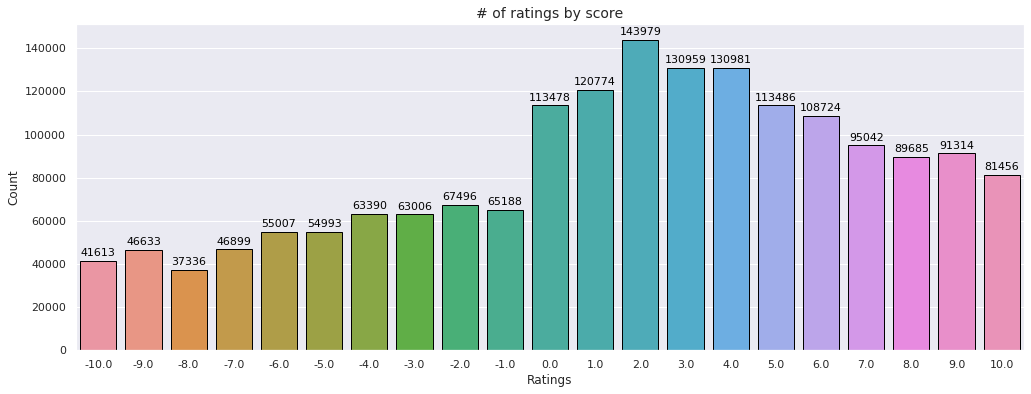

In [26]:
# setting plot style & size
sns.set(style='darkgrid')
plt.figure(figsize=(17, 6))

# rendering plot
sns.barplot(x=target_col, y=item_col, data=class_dist_df, edgecolor='black')

# adding chart title
plt.title('# of ratings by score', size=14)

# adding custom labels for axes
plt.ylabel('Count')
plt.xlabel('Ratings')

# adding labels on data points
for index, row in class_dist_df.iterrows():
    plt.text(index, row.jokeId + (max_count // 100) * 1.5, row.jokeId.astype('int'), color='black', ha="center", size=11)

## ***Data Preparation***

###***Data Split - Train/Validation***

In [0]:
work_data = raw_data.copy()

In [0]:
def data_split(data, ratio, save_data=True, load_data=True):
    # Data split part
    train_data, testval_data = train_test_split(data, test_size=ratio, random_state=10, stratify=data[target_col])
    val_data, test_data = train_test_split(testval_data, test_size=0.5, random_state=10, stratify=testval_data[target_col])

    # Setting variables
    file_contents = [train_data, val_data, test_data]
    file_names = ['train_data.csv', 'val_data.csv', 'test_data.csv']

    # Reseting indices on data
    for contents in file_contents:
        contents.reset_index(drop=True, inplace=True)

    # Saving data to csv files
    if save_data:
        for name, contents in zip(file_names, file_contents):
            contents.to_csv(path_or_buf=DATA_DIR/name, index=False, header=True)
    
    # Loading data from csv files
    if load_data:
        for name, contents in zip(file_names, file_contents):
            contents = pd.read_csv(DATA_DIR/name, low_memory=False)
    
    return train_data, test_data, val_data

In [0]:
train_data, test_data, val_data = data_split(data=work_data, ratio=0.1)

In [30]:
# Checking the shapes of splited data
[x.shape for x in (train_data, val_data, test_data)]

[(1585295, 4), (88072, 4), (88072, 4)]

In [31]:
train_data.head()

,userId,jokeId,rating,new_rating
0,36445,19,1.438,1.0
1,2727,13,3.781,4.0
2,33219,53,5.562,6.0
3,30926,141,-9.250,-9.0
4,36586,104,3.125,3.0


In [32]:
rates = train_data[target_col].unique()
rates.sort()
rates

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

### ***Data Preprocessing***

In [0]:
target_col = 'rating'

In [0]:
def data_scale(data, save_scaler=True, load_scaler=True):
    scale_data = data.copy()

    # Saving scaler for target column into the file
    if save_scaler:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(scale_data[[target_col]])
        with open(MODEL_DIR/'scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f, pickle.HIGHEST_PROTOCOL)

    # Loading scaler for target column from the file
    if load_scaler:
        with open(MODEL_DIR/'scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        scale_data[target_col] = scaler.transform(scale_data[[target_col]])

    return scale_data, scaler

In [35]:
train_data[target_col].values[:10]

array([ 1.438,  3.781,  5.562, -9.25 ,  3.125,  6.5  ,  2.531,  1.906,
        0.031,  2.125])

In [0]:
train_data, scaler = data_scale(train_data)

In [0]:
val_data, _ = data_scale(val_data, save_scaler=False)

In [38]:
train_data.head()

,userId,jokeId,rating,new_rating
0,36445,19,0.1438,1.0
1,2727,13,0.3781,4.0
2,33219,53,0.5562,6.0
3,30926,141,-0.9250,-9.0
4,36586,104,0.3125,3.0


In [39]:
scaler.inverse_transform(train_data[[target_col]][:10]).flatten()

array([ 1.438,  3.781,  5.562, -9.25 ,  3.125,  6.5  ,  2.531,  1.906,
        0.031,  2.125])

### ***Dataset Creation***

In [0]:
BATCH_SIZE = 4096
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [41]:
print('Maximum User ID:')
print(f'Train data - {train_data[user_col].max()}.')
print(f'Validation data - {val_data[user_col].max()}.\n')

print('Maximum Joke ID:')
print(f'Train data - {train_data[item_col].max()}.')
print(f'Validation data - {val_data[item_col].max()}.')

Maximum User ID:
Train data - 63978.
Validation data - 63978.

Maximum Joke ID:
Train data - 150.
Validation data - 150.


In [42]:
n_users = int(round(max(train_data[user_col].max(), val_data[user_col].max()) * 1.05, -3))
n_users

67000

In [43]:
n_items = int(round(max(train_data[item_col].max(), val_data[item_col].max()) * 1.1, -1))
n_items

160

In [0]:
def make_dataset(data, train_set=True):
    dataset = tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices((data[user_col].values, data[item_col].values)),
            tf.data.Dataset.from_tensor_slices(data[target_col].values),
        )
    )
    if train_set:
        dataset = dataset.cache()
        dataset = dataset.repeat()
        dataset = dataset.shuffle(buffer_size=len(data))
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [0]:
train_dataset = make_dataset(train_data, train_set=True)
train_dataset_steps = math.ceil(len(train_data) / BATCH_SIZE)

In [0]:
val_dataset = make_dataset(val_data, train_set=False)

In [47]:
train_dataset.element_spec

((TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None,), dtype=tf.float64, name=None))

In [48]:
for xs, ys in train_dataset.take(1):
    print(xs[0].shape, xs[1].shape, ys.shape)
    print(xs[0], xs[1])
    print(ys[0])

(4096,) (4096,) (4096,)
tf.Tensor([42067 12809 32668 ... 40406 50994 55057], shape=(4096,), dtype=int64) tf.Tensor([  7 130 124 ... 105 144 101], shape=(4096,), dtype=int64)
tf.Tensor(0.1406, shape=(), dtype=float64)


## ***Exploring Different Model Architectures***

### ***Utilities & Setup***

In [0]:
def plot_history(history, contains, skip=0):
    _, ax = plt.subplots(1, len(contains), figsize=(20, 5))

    df = pd.DataFrame(history.history)
    for idx, item in enumerate(contains):
        ax[idx].plot(df[list(df.filter(regex=item))].iloc[skip:])
        ax[idx].set_title(item)

In [0]:
def model_capture(model, name, history, save_model=True, load_model=True):
    name = name.strip().replace(' ', '_').lower()
    architecture_path = str(Path(MODEL_DIR/f'{name}_weights.h5'))
    weights_path = str(Path(MODEL_DIR/f'{name}_arch.json'))
    history_path = str(Path(MODEL_DIR/f'{name}_hist.csv'))

    # Saving model weights and architecture into the files
    if save_model:
        model.save_weights(weights_path)
        with open(architecture_path, "w") as f:
            f.write(model.to_json())
        
        pd.DataFrame(history.history).to_csv(path_or_buf=history_path, index=False, header=True)
    
    # Loading model weights and architecture from the files
    if load_model:
        with open(architecture_path, "r") as f:
            model = keras.models.model_from_json(f.read())
        model.load_weights(weights_path)
    
    return model

In [0]:
def model_predictions(model, dataset):
    labels = np.concatenate(
        [y.numpy().reshape(-1, 1) for _, y in dataset]
    )
    predictions = model.predict(dataset)
    return labels, predictions

In [0]:
def model_metric(model, dataset, scaler):
    labels, predictions = model_predictions(model, dataset)

    rmse = keras.metrics.RootMeanSquaredError()
    rmse.update_state(scaler.inverse_transform(labels), scaler.inverse_transform(predictions))

    return rmse.result().numpy()

In [0]:
EPOCHS = 50
PATIENCE = max(EPOCHS // 10, 3)

In [0]:
LEARN_RATE = 3e-4
L1_REG = 1e-4
L2_REG = 1e-6
DROPOUT = 0.2

In [0]:
callbacks=[
    keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
    keras.callbacks.EarlyStopping(patience=int(PATIENCE * 2.5), restore_best_weights=True),
    keras.callbacks.TerminateOnNaN(),
]

In [0]:
# Preparing to capture models & metrics
model_metrics = pd.DataFrame(columns=['RMSE', 'History'])

### ***Concat Model***

In [0]:
def make_concat_model(
    user_dim,
    item_dim,
    embedding_dim,
    layer_size=256,
    dropout_rate=0.0,
    regularization=None,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(user_dim, embedding_dim, input_length=1,)(user_input)
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1,)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(item_dim, embedding_dim, input_length=1,)(item_input)
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1,)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    x = keras.layers.Concatenate()([user_embedding, user_bias, item_embedding, item_bias])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        layer_size,
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
    )(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(1)(x)
    outputs = keras.layers.Activation(keras.activations.tanh)(x)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [0]:
model = make_concat_model(
    user_dim=n_users,
    item_dim=n_items,
    embedding_dim=128,
    layer_size=256,
    dropout_rate=DROPOUT,
    regularization=(L1_REG, L2_REG),
)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       8576000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 1)         67000       input_1[0][0]                    
______________________________________________________________________________________________

In [0]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=LEARN_RATE),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae, keras.metrics.RootMeanSquaredError()],
)

In [0]:
model_history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2,
)

Train for 388 steps, validate for 22 steps
Epoch 1/50
388/388 - 48s - loss: 0.8195 - mean_absolute_error: 0.4854 - root_mean_squared_error: 0.6167 - val_loss: 0.6081 - val_mean_absolute_error: 0.3980 - val_root_mean_squared_error: 0.4879
Epoch 2/50
388/388 - 44s - loss: 0.5077 - mean_absolute_error: 0.3558 - root_mean_squared_error: 0.4515 - val_loss: 0.4287 - val_mean_absolute_error: 0.3437 - val_root_mean_squared_error: 0.4333
Epoch 3/50
388/388 - 44s - loss: 0.3682 - mean_absolute_error: 0.3317 - root_mean_squared_error: 0.4260 - val_loss: 0.3190 - val_mean_absolute_error: 0.3324 - val_root_mean_squared_error: 0.4262
Epoch 4/50
388/388 - 44s - loss: 0.2750 - mean_absolute_error: 0.3251 - root_mean_squared_error: 0.4200 - val_loss: 0.2455 - val_mean_absolute_error: 0.3313 - val_root_mean_squared_error: 0.4248
Epoch 5/50
388/388 - 44s - loss: 0.2154 - mean_absolute_error: 0.3208 - root_mean_squared_error: 0.4159 - val_loss: 0.2041 - val_mean_absolute_error: 0.3295 - val_root_mean_squa

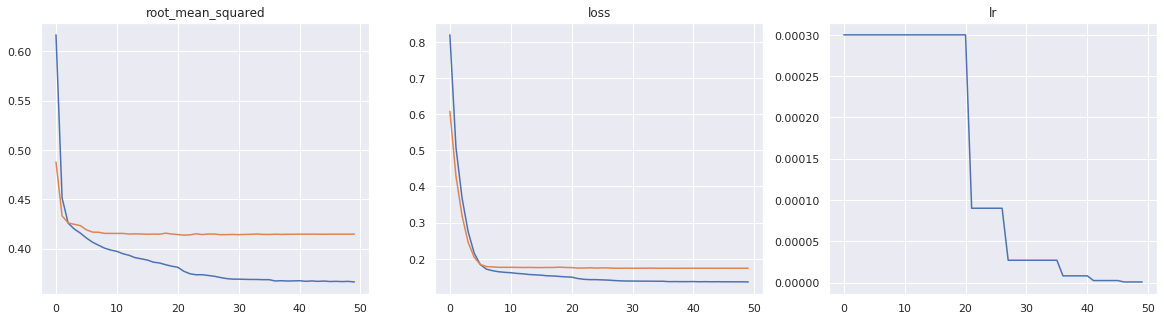

In [0]:
plot_history(model_history, ['root_mean_squared', 'loss', 'lr'])

In [0]:
model.evaluate(val_dataset)

22/22 [==============================] - 0s 19ms/step - loss: 0.1738 - mean_absolute_error: 0.3075 - root_mean_squared_error: 0.4146


[0.17377463321794162, 0.307454, 0.41456014]

In [0]:
model_name = 'Concat'
model_hist_file = f'{model_name.strip().replace(" ", "_").lower()}_hist.csv'
loaded_model = model_capture(model, model_name, model_history)

In [0]:
loaded_model.compile(
    optimizer=keras.optimizers.Adam(lr=LEARN_RATE),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae, keras.metrics.RootMeanSquaredError()],
)

In [0]:
loaded_model.evaluate(val_dataset)

22/22 [==============================] - 1s 26ms/step - loss: 0.1738 - mean_absolute_error: 0.3075 - root_mean_squared_error: 0.4146


[0.17377463321794162, 0.307454, 0.41456014]

In [0]:
del model

In [0]:
model_rmse = model_metric(loaded_model, val_dataset, scaler)
model_rmse

4.1456017

In [0]:
model_metrics.loc[f'{model_name} model', 'RMSE'] = model_rmse
model_metrics.loc[f'{model_name} model', 'History'] = model_hist_file

### ***Dot Model***

In [0]:
def make_dot_model(
    user_dim,
    item_dim,
    embedding_dim,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(user_dim, embedding_dim, input_length=1,)(user_input)
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1,)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(item_dim, embedding_dim, input_length=1,)(item_input)
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1,)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    logits = keras.layers.Add()([dot_product, user_bias, item_bias])
    outputs = keras.layers.Activation(keras.activations.tanh)(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [0]:
model = make_dot_model(
    user_dim=n_users,
    item_dim=n_items,
    embedding_dim=128,
)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 128)       8576000     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 128)       20480       input_4[0][0]                    
____________________________________________________________________________________________

In [0]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=LEARN_RATE),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae, keras.metrics.RootMeanSquaredError()],
)

In [0]:
model_history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2,
)

Train for 388 steps, validate for 22 steps
Epoch 1/50
388/388 - 48s - loss: 0.2850 - mean_absolute_error: 0.4487 - root_mean_squared_error: 0.5339 - val_loss: 0.2600 - val_mean_absolute_error: 0.4252 - val_root_mean_squared_error: 0.5099
Epoch 2/50
388/388 - 43s - loss: 0.2147 - mean_absolute_error: 0.3778 - root_mean_squared_error: 0.4634 - val_loss: 0.1910 - val_mean_absolute_error: 0.3486 - val_root_mean_squared_error: 0.4369
Epoch 3/50
388/388 - 43s - loss: 0.1633 - mean_absolute_error: 0.3156 - root_mean_squared_error: 0.4041 - val_loss: 0.1753 - val_mean_absolute_error: 0.3246 - val_root_mean_squared_error: 0.4187
Epoch 4/50
388/388 - 43s - loss: 0.1403 - mean_absolute_error: 0.2852 - root_mean_squared_error: 0.3746 - val_loss: 0.1702 - val_mean_absolute_error: 0.3158 - val_root_mean_squared_error: 0.4125
Epoch 5/50
388/388 - 43s - loss: 0.1217 - mean_absolute_error: 0.2602 - root_mean_squared_error: 0.3489 - val_loss: 0.1680 - val_mean_absolute_error: 0.3120 - val_root_mean_squa

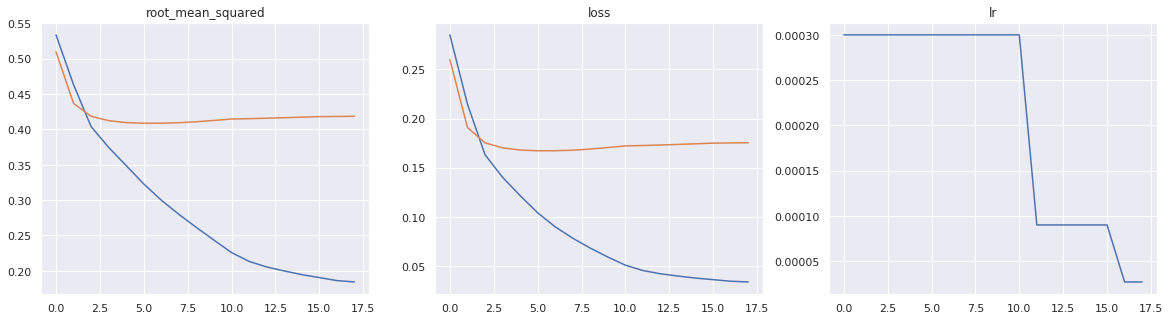

In [0]:
plot_history(model_history, ['root_mean_squared', 'loss', 'lr'])

In [0]:
model.evaluate(val_dataset)

22/22 [==============================] - 0s 18ms/step - loss: 0.1672 - mean_absolute_error: 0.3103 - root_mean_squared_error: 0.4088


[0.16720516776496713, 0.31033832, 0.40879577]

In [0]:
model_name = 'Dot Product'
model_hist_file = f'{model_name.strip().replace(" ", "_").lower()}_hist.csv'
loaded_model = model_capture(model, model_name, model_history)

In [0]:
loaded_model.compile(
    optimizer=keras.optimizers.Adam(lr=LEARN_RATE),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae, keras.metrics.RootMeanSquaredError()],
)

In [0]:
loaded_model.evaluate(val_dataset)

22/22 [==============================] - 0s 22ms/step - loss: 0.1672 - mean_absolute_error: 0.3103 - root_mean_squared_error: 0.4088


[0.16720516776496713, 0.31033832, 0.40879577]

In [0]:
del model

In [0]:
model_rmse = model_metric(loaded_model, val_dataset, scaler)
model_rmse

4.0879574

In [0]:
model_metrics.loc[f'{model_name} model', 'RMSE'] = model_rmse
model_metrics.loc[f'{model_name} model', 'History'] = model_hist_file

### ***Combo Model***

In [0]:
def make_combo_model(
    user_dim,
    item_dim,
    embedding_dim,
    layer_size=256,
    dropout_rate=0.0,
    regularization=None,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(user_dim, embedding_dim, input_length=1,)(user_input)
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1,)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(item_dim, embedding_dim, input_length=1,)(item_input)
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1,)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    concat = keras.layers.Concatenate()([user_embedding, user_bias, item_embedding, item_bias])
    concat = keras.layers.BatchNormalization()(concat)
    concat = keras.layers.Dropout(dropout_rate)(concat)
    concat = keras.layers.Dense(
        layer_size,
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
    )(concat)
    concat = keras.layers.LeakyReLU()(concat)
    concat = keras.layers.BatchNormalization()(concat)
    concat = keras.layers.Dropout(dropout_rate)(concat)
    concat = keras.layers.Dense(1)(concat)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    dot_product = keras.layers.Add()([dot_product, user_bias, item_bias])

    combo = keras.layers.Concatenate()([concat, dot_product])
    combo = keras.layers.Dense(1)(combo)
    outputs = keras.layers.Activation(keras.activations.tanh)(combo)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [0]:
model = make_combo_model(
    user_dim=n_users,
    item_dim=n_items,
    embedding_dim=128,
    layer_size=256,
    dropout_rate=DROPOUT,
    regularization=(L1_REG, L2_REG),
)

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 128)       8576000     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 1)         67000       input_5[0][0]                    
____________________________________________________________________________________________

In [0]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=LEARN_RATE),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae, keras.metrics.RootMeanSquaredError()],
)

In [0]:
model_history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2,
)

Train for 388 steps, validate for 22 steps
Epoch 1/50
388/388 - 47s - loss: 0.7631 - mean_absolute_error: 0.4561 - root_mean_squared_error: 0.5798 - val_loss: 0.6222 - val_mean_absolute_error: 0.4484 - val_root_mean_squared_error: 0.5248
Epoch 2/50
388/388 - 43s - loss: 0.4745 - mean_absolute_error: 0.3496 - root_mean_squared_error: 0.4456 - val_loss: 0.3994 - val_mean_absolute_error: 0.3468 - val_root_mean_squared_error: 0.4336
Epoch 3/50
388/388 - 43s - loss: 0.3393 - mean_absolute_error: 0.3304 - root_mean_squared_error: 0.4247 - val_loss: 0.2934 - val_mean_absolute_error: 0.3344 - val_root_mean_squared_error: 0.4264
Epoch 4/50
388/388 - 43s - loss: 0.2511 - mean_absolute_error: 0.3237 - root_mean_squared_error: 0.4184 - val_loss: 0.2265 - val_mean_absolute_error: 0.3316 - val_root_mean_squared_error: 0.4244
Epoch 5/50
388/388 - 43s - loss: 0.2004 - mean_absolute_error: 0.3200 - root_mean_squared_error: 0.4151 - val_loss: 0.1932 - val_mean_absolute_error: 0.3288 - val_root_mean_squa

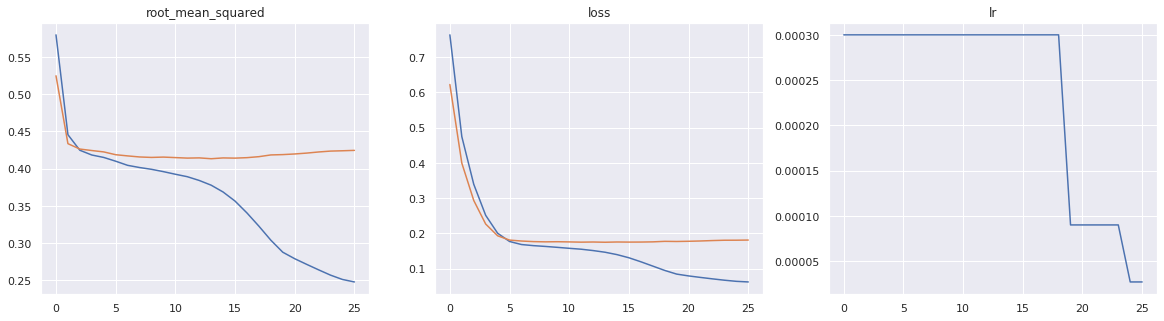

In [0]:
plot_history(model_history, ['root_mean_squared', 'loss', 'lr'])

In [0]:
model.evaluate(val_dataset)

22/22 [==============================] - 0s 19ms/step - loss: 0.1749 - mean_absolute_error: 0.3118 - root_mean_squared_error: 0.4134


[0.17485847933725876, 0.31183013, 0.41336685]

In [0]:
model_name = 'Combo'
model_hist_file = f'{model_name.strip().replace(" ", "_").lower()}_hist.csv'
loaded_model = model_capture(model, model_name, model_history)

In [0]:
loaded_model.compile(
    optimizer=keras.optimizers.Adam(lr=LEARN_RATE),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae, keras.metrics.RootMeanSquaredError()],
)

In [0]:
loaded_model.evaluate(val_dataset)

22/22 [==============================] - 1s 27ms/step - loss: 0.1749 - mean_absolute_error: 0.3118 - root_mean_squared_error: 0.4134


[0.17485847933725876, 0.31183013, 0.41336685]

In [0]:
del model

In [0]:
model_rmse = model_metric(loaded_model, val_dataset, scaler)
model_rmse

4.133669

In [0]:
model_metrics.loc[f'{model_name} model', 'RMSE'] = model_rmse
model_metrics.loc[f'{model_name} model', 'History'] = model_hist_file

In [0]:
model_metrics[['RMSE']]

,RMSE
Concat model,4.1456
Dot Product model,4.08796
Combo model,4.13367


## ***Hyperparameter Tuning***

### ***Keras Tuner - Random Search***

In [0]:
def make_hp_dot_model(hp):
    user_dim = hp.Fixed("user_dim", 1)
    item_dim = hp.Fixed("item_dim", 1)
    embedding_dim = hp.Choice("embedding_dim", [16, 32, 64, 128, 256])

    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(
        user_dim,
        embedding_dim,
        embeddings_regularizer=keras.regularizers.l2(
            hp.Float(
                "user_embeddings_regularization_l2",
                min_value=1e-8,
                max_value=5e-2,
                sampling="log",
            )
        ),
        input_length=1,
    )(user_input)
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_embedding = keras.layers.Dropout(
        hp.Float("user_embedding_dropout", min_value=0.0, max_value=0.8, step=0.1)
    )(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1,)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(
        item_dim, 
        embedding_dim, 
        embeddings_regularizer=keras.regularizers.l2(
            hp.Float(
                "item_embeddings_regularization_l2",
                min_value=1e-8,
                max_value=5e-2,
                sampling="log",
            )
        ),
        input_length=1,
    )(item_input)
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_embedding = keras.layers.Dropout(
        hp.Float("item_embedding_dropout", min_value=0.0, max_value=0.8, step=0.1)
    )(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1,)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    logits = keras.layers.Add()([dot_product, user_bias, item_bias])
    outputs = keras.layers.Activation(keras.activations.tanh)(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", [3e-3, 1e-3, 5e-4, 3e-4, 1e-4])
        ),
        loss=keras.losses.mse,
        metrics=[keras.metrics.mae, keras.metrics.RootMeanSquaredError()],
    )
    return model

In [0]:
hp = kt.HyperParameters()
hp.Fixed("user_dim", n_users)
hp.Fixed("item_dim", n_items)

tuner = kt.tuners.RandomSearch(
    make_hp_dot_model,
    objective="val_loss",
    max_trials=30,
    hyperparameters=hp,
    directory=MODEL_DIR,
    project_name="hyper_dot_model_3",
)

In [0]:
tuner.search_space_summary()

In [0]:
tuner.search(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=0,
)

/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Oracle triggered exit


In [0]:
tuned_models = tuner.get_best_models(num_models=5)

In [0]:
[tuned_models[i].evaluate(val_dataset) for i in range(5)]

22/22 [==============================] - 0s 21ms/step - loss: 0.1767 - mean_absolute_error: 0.3123 - root_mean_squared_error: 0.4075


[[0.16667743704535745, 0.30931762, 0.40771574],
 [0.16996756331487137, 0.31070343, 0.4107687],
 [0.17032155936414545, 0.3075532, 0.4086319],
 [0.17151365700093182, 0.30613527, 0.40276256],
 [0.17667461186647415, 0.3123318, 0.40747985]]

### ***Hyper Tuned Model***

In [0]:
def make_tuned_model(
    user_dim,
    item_dim,
    embedding_dim,
    user_embedding_reg_l2,
    user_embedding_dropout,
    item_embedding_reg_l2,
    item_embedding_dropout,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(
        user_dim,
        embedding_dim,
        embeddings_regularizer=keras.regularizers.l2(l=user_embedding_reg_l2),
        input_length=1,
    )(user_input)
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_embedding = keras.layers.Dropout(rate=user_embedding_dropout)(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1,)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(
        item_dim, 
        embedding_dim, 
        embeddings_regularizer=keras.regularizers.l2(l=item_embedding_reg_l2),
        input_length=1,
    )(item_input)
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_embedding = keras.layers.Dropout(rate=item_embedding_dropout)(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1,)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    logits = keras.layers.Add()([dot_product, user_bias, item_bias])
    outputs = keras.layers.Activation(keras.activations.tanh)(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [0]:
# |-embedding_dim: 16
# |-item_dim: 160
# |-item_embedding_dropout: 0.2
# |-item_embeddings_regularization_l2: 1.3488519705713262e-08
# |-learning_rate: 0.0005
# |-user_dim: 67000
# |-user_embedding_dropout: 0.8
# |-user_embeddings_regularization_l2: 7.429678530403645e-08
# |-Score: 0.16667743704535745

LEARN_RATE = 5e-4
EMBEDDINGS = 16

USER_REG_L2 = 7.429678530403645e-08
USER_DROPOUT = 0.8 

ITEM_REG_L2 = 1.3488519705713262e-08
ITEM_DROPOUT = 0.2

In [58]:
model = make_tuned_model(
    user_dim=n_users,
    item_dim=n_items,
    embedding_dim=EMBEDDINGS,
    user_embedding_reg_l2=USER_REG_L2,
    user_embedding_dropout=USER_DROPOUT,
    item_embedding_reg_l2=ITEM_REG_L2,
    item_embedding_dropout=ITEM_DROPOUT,
)

In [59]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 16)        1072000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 16)        2560        input_2[0][0]                    
______________________________________________________________________________________________

In [0]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=LEARN_RATE),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae, keras.metrics.RootMeanSquaredError()],
)

In [61]:
model_history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2,
)

Train for 388 steps, validate for 22 steps
Epoch 1/50


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


388/388 - 12s - loss: 0.2735 - mean_absolute_error: 0.4374 - root_mean_squared_error: 0.5229 - val_loss: 0.2510 - val_mean_absolute_error: 0.4145 - val_root_mean_squared_error: 0.5009
Epoch 2/50
388/388 - 8s - loss: 0.2371 - mean_absolute_error: 0.3994 - root_mean_squared_error: 0.4868 - val_loss: 0.2292 - val_mean_absolute_error: 0.3901 - val_root_mean_squared_error: 0.4786
Epoch 3/50
388/388 - 8s - loss: 0.2176 - mean_absolute_error: 0.3778 - root_mean_squared_error: 0.4664 - val_loss: 0.2116 - val_mean_absolute_error: 0.3707 - val_root_mean_squared_error: 0.4598
Epoch 4/50
388/388 - 7s - loss: 0.2013 - mean_absolute_error: 0.3594 - root_mean_squared_error: 0.4486 - val_loss: 0.1972 - val_mean_absolute_error: 0.3544 - val_root_mean_squared_error: 0.4439
Epoch 5/50
388/388 - 7s - loss: 0.1904 - mean_absolute_error: 0.3462 - root_mean_squared_error: 0.4362 - val_loss: 0.1887 - val_mean_absolute_error: 0.3439 - val_root_mean_squared_error: 0.4342
Epoch 6/50
388/388 - 7s - loss: 0.1843 -

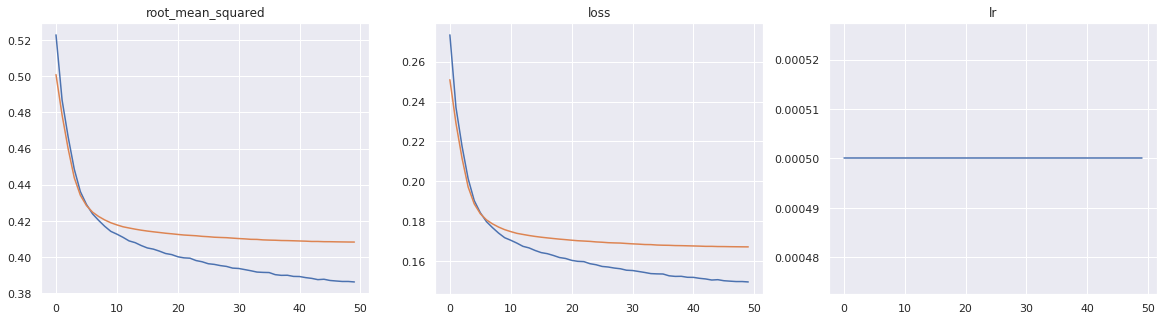

In [62]:
plot_history(model_history, ['root_mean_squared', 'loss', 'lr'])

In [63]:
model.evaluate(val_dataset)

22/22 [==============================] - 0s 14ms/step - loss: 0.1672 - mean_absolute_error: 0.3097 - root_mean_squared_error: 0.4083


[0.1671589050780643, 0.30971345, 0.40830803]

In [64]:
model_name = 'Tuned Dot Product'
model_hist_file = f'{model_name.strip().replace(" ", "_").lower()}_hist.csv'
loaded_model = model_capture(model, model_name, model_history)

In [0]:
loaded_model.compile(
    optimizer=keras.optimizers.Adam(lr=LEARN_RATE),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae, keras.metrics.RootMeanSquaredError()],
)

In [66]:
loaded_model.evaluate(val_dataset)

22/22 [==============================] - 0s 19ms/step - loss: 0.1672 - mean_absolute_error: 0.3097 - root_mean_squared_error: 0.4083


[0.1671589050780643, 0.30971345, 0.40830803]

In [0]:
del model

In [68]:
model_rmse = model_metric(loaded_model, val_dataset, scaler)
model_rmse

4.0830803

In [0]:
model_metrics.loc[f'{model_name} model', 'RMSE'] = model_rmse
model_metrics.loc[f'{model_name} model', 'History'] = model_hist_file

In [72]:
model_metrics[['RMSE']]

,RMSE
Tuned Dot Product model,4.08308


### ***Model Evaluation with Test Data***

In [0]:
test_data, _ = data_scale(test_data, save_scaler=False)

In [0]:
test_dataset = make_dataset(test_data, train_set=False)

In [75]:
model_rmse = model_metric(loaded_model, test_dataset, scaler)
model_rmse

4.099521